In [ ]:
import os
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from distance import distance_calculator
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import multiprocessing
from plot_imerg_for_mrms_Storm_Total import imerg_for_mrms
import geopandas as gpd
import shapely.geometry as geom
from sh import gunzip
import pickle
from multiprocessing import Pool
from shapely.geometry import Point


In [ ]:
data_type = "MRMS"
SHIPS = pd.read_csv('/Users/acheung/data/SHIPS/all_SHIPs_data_combined_north_atlantic.csv')
SHIPS = SHIPS.where(pd.to_datetime(SHIPS['Time']) >= dt.datetime(2015,5,6)).dropna()
near_land_cases = SHIPS.where(SHIPS['DTL'] <50).dropna()


In [ ]:
# def min_distance(point, lines):
#     return lines.distance(point).min()
# dist_list = []
# for ships_inds in near_land_cases.index:

#     coastline = gpd.read_file('/Users/acheung/data/Shapefiles/tl_2024_us_coastline.shp')
#     coastline = coastline.where(
#         (coastline['NAME'] == 'Gulf') | (coastline['NAME'] == 'Atlantic')).dropna()
    
#     PR_inds = list([271,277,list(np.arange(281,304)),list(np.arange(920,935))])

#     def flatten(test_list):
#         if isinstance(test_list, list):
#             temp = []
#             for ele in test_list:
#                 temp.extend(flatten(ele))
#             return temp
#         else:
#             return [test_list]

#     flattened_pr = flatten(PR_inds)
    
#     coastline_no_pr = coastline.drop(flattened_pr)

#     # coastline = gpd.clip(gpd.read_file('ne_10m_coastline.shp'), us).to_crs('EPSG:3087')
#     coastline_no_pr = coastline_no_pr.to_crs('EPSG:3087')
#     points_df = gpd.GeoDataFrame({
#         'geometry': [
#             Point(360-SHIPS['LON'].loc[ships_inds], SHIPS['LAT'].loc[ships_inds])]}, crs='EPSG:4326')
#     points_df = points_df.to_crs('EPSG:3087') # https://epsg.io/3087

#     points_df['min_dist_to_coast'] = points_df.geometry.apply(min_distance, args=(coastline_no_pr,))
#     print((points_df['min_dist_to_coast']/1000)[0])
#     dist = (points_df['min_dist_to_coast']/1000)[0]
#     dist_list.append(dist)
# distances_to_us_coast = pd.DataFrame(dist_list,index = near_land_cases.index)
# distances_to_us_coast.to_csv('/Users/acheung/data/intermediates/dists_to_us_coast_50.csv')

In [ ]:
distances_to_us_coast = pd.read_csv('/Users/acheung/data/intermediates/dists_to_us_coast_50.csv')['0']
distances_to_us_coast.index = near_land_cases.index

In [ ]:
near_us_coast_cases = near_land_cases.loc[distances_to_us_coast.where(distances_to_us_coast < 100).dropna().index]
atcf_ids = near_us_coast_cases['Storm_ID'].unique()


In [ ]:
interpolated_mrms_list = []
imerg_precip_list = []
lat_lon_arr_list = []
time_strings_list = []
for atcf_it in range(len(atcf_ids)):
# for atcf_it in [35]:
    current_near_land_case = near_us_coast_cases.where(near_land_cases['Storm_ID'] == atcf_ids[atcf_it]).dropna()
    current_storm_name = str(current_near_land_case['Name'].unique()[0])
    current_storm_ID = str(current_near_land_case['Storm_ID'].unique()[0])

    desired_lat = current_near_land_case['LAT'].mean()
    desired_lon = 360-current_near_land_case['LON'].mean()

    start_str = current_near_land_case['Time'].iloc[0]
    end_str = str(pd.to_datetime(current_near_land_case['Time'].iloc[-1]) + dt.timedelta(hours=24)) # Add 24 hours after best-track ends!
    time_strings_list.append(start_str + ', end = ' + end_str)
    
    times_pd = pd.date_range(start=start_str,end=end_str, freq='1h')
    times_pd = times_pd[0:-1] + dt.timedelta(hours=1) # We offset the MRMS time by one hour because the timestamp is at the end of one hour time window

    filepaths = []
    problematic_times = []
    for i in times_pd: # Download all the desired IMERG Images
        # If IMERG file does not exist, download it

        year = i.strftime('%Y')
        month = i.strftime('%m')
        day =  i.strftime('%d')
        hour = i.strftime('%H')

        if (times_pd[0]).to_pydatetime() >= dt.datetime(2020,10,15): # Switch to dual-pol led to file directory change! Keep this in mind!
            data_file_path = '/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day+\
                '/MultiSensor_QPE_01H_Pass2_00.00_' + year+month+day+'-'+hour+'0000.grib2'
            url_desired = "https://mtarchive.geol.iastate.edu/"+year+"/"+month+"/"+day+"/mrms/ncep/MultiSensor_QPE_01H_Pass2/"\
                + 'MultiSensor_QPE_01H_Pass2_00.00_' + year+month+day+'-'+hour+'0000.grib2.gz'

        elif (times_pd[0]).to_pydatetime() < dt.datetime(2020,10,15): # Switch to dual-pol led to file directory change! Keep this in mind!
            data_file_path = '/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day+\
                '/GaugeCorr_QPE_01H_00.00_' + year+month+day+'-'+hour+'0000.grib2'
            url_desired = "https://mtarchive.geol.iastate.edu/"+year+"/"+month+"/"+day+"/mrms/ncep/GaugeCorr_QPE_01H/"\
                + 'GaugeCorr_QPE_01H_00.00_' + year+month+day+'-'+hour+'0000.grib2.gz'

    # If day directory does not exist, make day directory
        if os.path.exists('/Users/acheung/data/MRMS/'+year) == False:
            os.mkdir('/Users/acheung/data/MRMS/'+year)

        if os.path.exists('/Users/acheung/data/MRMS/'+year+'/'+month) == False:
            os.mkdir('/Users/acheung/data/MRMS/'+year+'/'+month)

        if os.path.exists('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day) == False:
            os.mkdir('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day)

        if os.path.exists(data_file_path) == False:

            os.chdir('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day)
            try:
                os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                          + url_desired)
                # wget.download(url_desired)
                gunzip(data_file_path+'.gz')
                # os.system('gzip -d '+data_file_path+'.gz')
            except:
                problematic_times.append(i)
                print('Skipped MRMS time ' + str(i))
                continue
        filepaths.append(data_file_path)
        problematic_times_arr = np.asarray(problematic_times) # More or less, remove any times from imerg that mrms did not have
    # ---------------------------------------------------------------------------------------------------------


    # Use multiprocessing to slice MRMS or Stage IV Data (speeds up process significantly)

    def slicing_file(case_loop,filepaths,desired_lon,desired_lat):
        import numpy as np
        import xarray as xr
        import sys
        sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
        from distance import distance_calculator

        ground_based_data = xr.open_dataset(filepaths[case_loop], engine="cfgrib")['unknown']
        x, y = np.float32(np.meshgrid(ground_based_data['longitude'], ground_based_data['latitude']))


        # Find index closest to interpolated best-track center or 2-km radar center
        distance_arr = distance_calculator(x,y,(desired_lon,desired_lat))

        abs_dist_arr = (abs(distance_arr))

        min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))

        # Slice arrays to within 400 indices of desired center

        sliced_lon_grid = x[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

        sliced_lat_grid = y[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

        sliced_ground_based_data = ground_based_data[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

        sliced_ground_based_data_masked = sliced_ground_based_data.where(sliced_ground_based_data.values >=0)
        return np.asarray([sliced_ground_based_data_masked,sliced_lon_grid,sliced_lat_grid])
    #-------------------------------------------------------------------------------------------------------

    # this helper function is needed because map() can only be used for functions
    # that take a single argument (see http://stackoverflow.com/q/5442910/1461210)
    def splat_slicing(args):
        return slicing_file(*args)

    pool = Pool(36)
    iteration_length = len(filepaths)

    def parallel_slicing(iteration_length):
        result_slicing = pool.map(splat_slicing, ((iteration,filepaths,desired_lon,desired_lat
                                                  ) for iteration in range(iteration_length)))
        # return np.asarray(result_slicing), result_slicing[0]['latitude'],result_slicing[0]['longitude']
        return result_slicing

    # ground_total_precip,sliced_lat_1d,sliced_lon_1d= parallel_slicing(iteration_length)
    result_slicing= parallel_slicing(iteration_length)
    mrms_array = np.asarray(result_slicing)
    ground_total_precip = mrms_array[:,0]
    mrms_y_grid = mrms_array[0,2]
    mrms_x_grid = mrms_array[0,1]
    mrms_x_grid = mrms_x_grid - 360
    
    #-------------------------------------------------------------------------------------------------------
    
    # Sum up precipitation (MRMS data is hourly QPE)
    summed_precip_post = np.sum(ground_total_precip,axis=0)

     #------------------------Process IMERG data based on MRMS Used-------------------------------------------

    imerg_for_mrms(start_str,end_str,desired_lon,desired_lat,problematic_times_arr)

    imerg_precip_data = xr.open_dataset('/Users/acheung/data/intermediates/start = '+start_str+', end = '+end_str+' imerg.nc')['__xarray_dataarray_variable__']
    
    #-------------------------------------Begin Barnes Analysis----------------------------------
    def Barnes_Point_Value(ind_zero_loop, ind_one_loop,imerg_precip_data, summed_precip_post,mrms_x_grid,mrms_y_grid,dataset_smoothed):
        # Perform your desired operation
    
        if dataset_smoothed == 'MRMS':
            euclidian_dist = np.sqrt(((imerg_precip_data['lat'].values[ind_zero_loop][ind_one_loop] - mrms_y_grid)**2) +
                                 ((imerg_precip_data['lon'].values[ind_zero_loop][ind_one_loop] - mrms_x_grid)**2))
        elif dataset_smoothed == 'IMERG':
            euclidian_dist = np.sqrt(((imerg_precip_data['lat'].values[ind_zero_loop][ind_one_loop] - imerg_precip_data['lat'].values)**2) +
                         ((imerg_precip_data['lon'].values[ind_zero_loop][ind_one_loop] - imerg_precip_data['lon'].values)**2))

        interested_euclid = pd.DataFrame(euclidian_dist).where(euclidian_dist < 1)
        c = 0.05 # std setting

        weight_func = np.exp(-(interested_euclid**2)/(2*(c**2)))
        norm_weight_func = weight_func/(weight_func.sum().sum())

        if dataset_smoothed == 'MRMS':
            this_point_value = np.nansum(norm_weight_func * summed_precip_post)
        elif dataset_smoothed == 'IMERG':
            this_point_value = np.nansum(norm_weight_func * imerg_precip_data.values)

        return this_point_value

#----------------------------Multiprocessing for Barnes Analysis---------------------------------------------


    # this helper function is needed because map() can only be used for functions
    # that take a single argument (see http://stackoverflow.com/q/5442910/1461210)
    def splat_barnes(args):
        return Barnes_Point_Value(*args)

    # a pool of 36 worker processes
    pool = Pool(36)
    M_barnes = imerg_precip_data['lat'].values.shape[0]
    N_barnes = imerg_precip_data['lat'].values.shape[1]

    def parallel_barnes(M_barnes, N_barnes,imerg_or_mrms):
        result_barnes_imerg = pool.map(splat_barnes, ((ind_zero_loop, ind_one_loop,imerg_precip_data, 
                                          summed_precip_post,mrms_x_grid,mrms_y_grid,imerg_or_mrms) 
                                         for ind_zero_loop in range(M_barnes) for ind_one_loop in range(N_barnes)))

        return np.array(np.asarray(result_barnes_imerg)).reshape(M_barnes, N_barnes)
    
    full_barnes_imerg = parallel_barnes(M_barnes, N_barnes,'IMERG')
    full_imerg_barnes_arr = np.asarray(full_barnes_imerg)

    full_barnes_mrms = parallel_barnes(M_barnes, N_barnes,'MRMS')
    full_mrms_barnes_arr = np.asarray(full_barnes_mrms)

#---------------------------Mask Data off coastline------------------------------------------
    
    # Mask Ocean from MRMS and IMERG
    # prepare temporary plot and create mask from rasterized map
    proj = {'projection': cartopy.crs.PlateCarree()}
    fig, ax = plt.subplots(figsize=(imerg_precip_data.shape[0]/100, imerg_precip_data.shape[1]/100), dpi=100, subplot_kw=proj)
    fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)
    ax.set_frame_on(False)

    ax.add_feature(cartopy.feature.OCEAN, facecolor='black')


    ax.set_extent((float(imerg_precip_data['lon'].min()),float(imerg_precip_data['lon'].max()),
                   float(imerg_precip_data['lat'].min()),float(imerg_precip_data['lat'].max())))
    fig.canvas.draw()
    mask = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    plt.close(fig)

    mask = np.frombuffer(mask, dtype=np.uint8).reshape(nrows, ncols, 3)
    mask = mask.mean(axis=2)
    mask = np.rot90(np.fliplr(mask),k=2)
    masked_mrms  = np.where(mask>0, full_mrms_barnes_arr, np.nan)
    masked_imerg  = np.where(mask>0, full_barnes_imerg, np.nan)
    imerg_precip_list.append(masked_imerg)
    interpolated_mrms_list.append(masked_mrms)
    
    #-------------------------------------End Barnes Analysis----------------------------------
    
    lat_lon_arr_list.append([imerg_precip_data['lat'].values, imerg_precip_data['lon'].values])
    print(str(atcf_it + 1) + ' of '+ str(len(atcf_ids)))

In [12]:
with open('/Users/acheung/data/intermediates/mrms_list.pkl', 'wb') as f:
    pickle.dump(interpolated_mrms_list, f)
    
with open('/Users/acheung/data/intermediates/lat_lon_list.pkl', 'wb') as f:
    pickle.dump(lat_lon_arr_list, f)
    
with open('/Users/acheung/data/intermediates/imerg_list.pkl', 'wb') as f:
    pickle.dump(imerg_precip_list, f)
    
with open('/Users/acheung/data/intermediates/time_strings_list.pkl', 'wb') as f:
    pickle.dump(time_strings_list, f)

In [6]:
with open('/Users/acheung/data/intermediates/mrms_list.pkl', 'rb') as file:
    # Load the data from the file
    interpolated_mrms_list = pickle.load(file)
    
with open('/Users/acheung/data/intermediates/lat_lon_list.pkl', 'rb') as file:
    # Load the data from the file
    lat_lon_arr_list = pickle.load(file)
    
with open('/Users/acheung/data/intermediates/imerg_list.pkl', 'rb') as file:
    # Load the data from the file
    imerg_precip_list = pickle.load(file)
    
with open('/Users/acheung/data/intermediates/time_strings_list.pkl', 'rb') as file:
    # Load the data from the file
    time_strings_list = pickle.load(file)


In [7]:
imerg_xr = xr.DataArray(imerg_precip_list)/25.4
mrms_xr = xr.DataArray(interpolated_mrms_list)/25.4
lat_lon_xr = xr.DataArray(lat_lon_arr_list)
# mrms_xr = mrms_xr.where(mrms_xr > 0)  

Text(0.5, 1.0, 'IMERG Before Barnes Analysis')

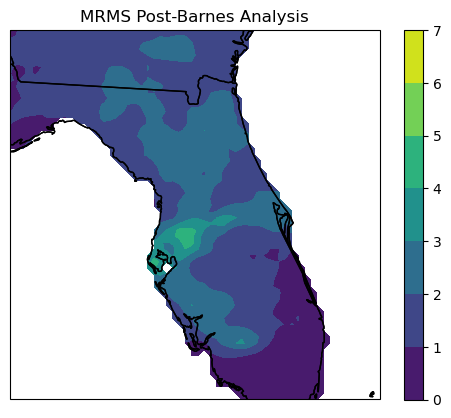

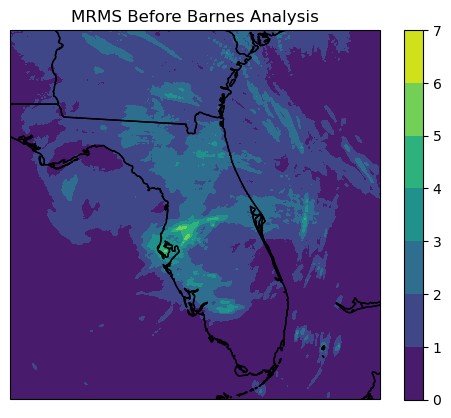

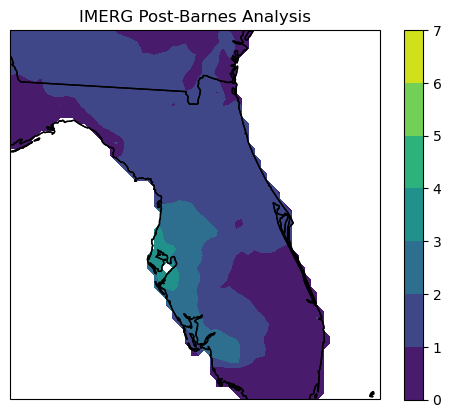

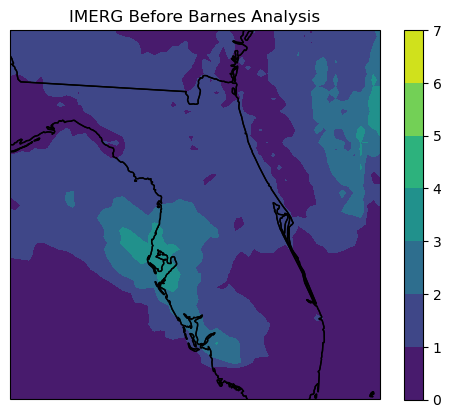

In [15]:
fig1 = plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
plot_1 = ax.contourf(imerg_precip_data['lon'].values,imerg_precip_data['lat'].values,masked_mrms/25.4,levels=np.arange(0,7.1,1))
plt.colorbar(plot_1)
ax.set_title('MRMS Post-Barnes Analysis')

fig2 = plt.figure()
ax2=plt.axes(projection=ccrs.PlateCarree())
ax2.add_feature(cfeature.STATES)
ax2.add_feature(cfeature.COASTLINE)
plot_2 = ax2.contourf(mrms_x_grid,mrms_y_grid,summed_precip_post/25.4,levels=np.arange(0,7.1,1))
plt.colorbar(plot_2)
ax2.set_title('MRMS Before Barnes Analysis')

full_imerg_barnes_arr = np.asarray(full_barnes_imerg)
fig3 = plt.figure()
ax3=plt.axes(projection=ccrs.PlateCarree())
ax3.add_feature(cfeature.STATES)
ax3.add_feature(cfeature.COASTLINE)
plot_3 = ax3.contourf(imerg_precip_data['lon'].values,imerg_precip_data['lat'].values,masked_imerg/25.4,
                      levels=np.arange(0,7.1,1))
plt.colorbar(plot_3)
ax3.set_title('IMERG Post-Barnes Analysis')


fig4 = plt.figure()
ax4=plt.axes(projection=ccrs.PlateCarree())
ax4.add_feature(cfeature.STATES)
ax4.add_feature(cfeature.COASTLINE)
plot_4 = ax4.contourf(imerg_precip_data['lon'],imerg_precip_data['lat'],imerg_precip_data/25.4,
                      levels=np.arange(0,7.1,1))
plt.colorbar(plot_4)
ax4.set_title('IMERG Before Barnes Analysis')


In [8]:
def fraction_calculator(lat_lon_xr_now,masked_imerg_xr,masked_mrms_xr,imerg_ind_0,imerg_ind_1,radius_to_include,thresholds):
    import sys
    sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
    from distance import distance_calculator
    import numpy as np
    import warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    # If the thresholds calculate from the same dataset (e.g., IMERG), it means that we are including bias
    imerg_threshold = np.nanpercentile(masked_imerg_xr,thresholds[0])
    mrms_threshold = np.nanpercentile(masked_imerg_xr,thresholds[-1])

    distance_arr_imerg = distance_calculator(lat_lon_xr_now[1].values,lat_lon_xr_now[0].values,
                                       (lat_lon_xr_now[1].values[imerg_ind_0,imerg_ind_1],
                                        lat_lon_xr_now[0].values[imerg_ind_0,imerg_ind_1]))

    inside_rad_imerg = (masked_imerg_xr.where(distance_arr_imerg < radius_to_include)).values.ravel()
    inside_rad_imerg_no_nan = inside_rad_imerg[~np.isnan(inside_rad_imerg)]
    fraction_rad_imerg = (inside_rad_imerg_no_nan > imerg_threshold).sum()/len(inside_rad_imerg_no_nan)
    
    distance_arr_mrms = distance_calculator(lat_lon_xr_now[1].values,lat_lon_xr_now[0].values,
                                       (lat_lon_xr_now[1].values[imerg_ind_0,imerg_ind_1],
                                        lat_lon_xr_now[0].values[imerg_ind_0,imerg_ind_1]))

    inside_rad_mrms = (masked_mrms_xr.where(distance_arr_mrms < radius_to_include)).values.ravel()
    inside_rad_mrms_no_nan = inside_rad_mrms[~np.isnan(inside_rad_mrms)]
    fraction_rad_mrms = (inside_rad_mrms_no_nan > mrms_threshold).sum()/len(inside_rad_mrms_no_nan)
    return np.asarray([fraction_rad_imerg,fraction_rad_mrms])


In [9]:
from multiprocessing import Pool

# Stack overflow: https://stackoverflow.com/questions/29857498/how-to-apply-a-function-to-a-2d-numpy-array-with-multiprocessing

def splat_f(args):
    return fraction_calculator(*args)

# a pool of 8 worker processes
pool = Pool()
M = imerg_xr.shape[1]
N = imerg_xr.shape[2]

def parallel(fraction_now_ind,M, N,radius_to_include,thresholds):
    lat_lon_xr_now = lat_lon_xr[fraction_now_ind]
    masked_imerg_xr = imerg_xr[fraction_now_ind]                     
    masked_mrms_xr = mrms_xr[fraction_now_ind]

    result = pool.map(splat_f, ((lat_lon_xr_now,masked_imerg_xr,masked_mrms_xr,
                                  imerg_ind_0,imerg_ind_1,radius_to_include,thresholds) for imerg_ind_0 in range(M) for imerg_ind_1 in range(N)))

    return np.array(np.asarray(result)[:,0]).reshape(M, N),np.array(np.asarray(result)[:,1]).reshape(M, N)


In [10]:
test_radii = np.concatenate([np.arange(10,60,5),np.arange(60,800.1,50)])
thresholds_wanted = [75,90,95,99]


In [19]:
# Calculate fractions in parallel

FSS_lists_with_all_thresholds = []
for thresholds_interested in thresholds_wanted:
    thresholds = [thresholds_interested]
    FSS_overall_list = []
    for fraction_now_ind in range(mrms_xr.shape[0]):
        FSS_list = []
        for radius_loop in test_radii:
            imerg_fractions,mrms_fractions = parallel(fraction_now_ind,M,N,radius_loop,thresholds)
            # print(str(radius_loop) + ' done')

            FBS = (np.nansum((mrms_fractions - imerg_fractions)**2))/len(imerg_fractions.ravel())
            FBS_worst = (np.nansum(mrms_fractions**2) + np.nansum(imerg_fractions**2))/len(imerg_fractions.ravel())
            FSS = 1 - (FBS/FBS_worst)
            FSS_list.append(FSS)
        FSS_overall_list.append(FSS_list)
        print(str(fraction_now_ind + 1) + ' of ' + str(mrms_xr.shape[0]) + '; Current Threshold: ' + str(thresholds_interested))
    FSS_lists_with_all_thresholds.append(FSS_overall_list)

with open('/Users/acheung/data/intermediates/FSS_list.pkl', 'wb') as f:
    pickle.dump(FSS_lists_with_all_thresholds, f)

1 of 42; Current Threshold: 75
2 of 42; Current Threshold: 75
3 of 42; Current Threshold: 75
4 of 42; Current Threshold: 75
5 of 42; Current Threshold: 75
6 of 42; Current Threshold: 75
7 of 42; Current Threshold: 75
8 of 42; Current Threshold: 75
9 of 42; Current Threshold: 75
10 of 42; Current Threshold: 75
11 of 42; Current Threshold: 75
12 of 42; Current Threshold: 75
13 of 42; Current Threshold: 75
14 of 42; Current Threshold: 75
15 of 42; Current Threshold: 75
16 of 42; Current Threshold: 75
17 of 42; Current Threshold: 75
18 of 42; Current Threshold: 75
19 of 42; Current Threshold: 75
20 of 42; Current Threshold: 75
21 of 42; Current Threshold: 75
22 of 42; Current Threshold: 75
23 of 42; Current Threshold: 75
24 of 42; Current Threshold: 75
25 of 42; Current Threshold: 75
26 of 42; Current Threshold: 75
27 of 42; Current Threshold: 75
28 of 42; Current Threshold: 75
29 of 42; Current Threshold: 75
30 of 42; Current Threshold: 75
31 of 42; Current Threshold: 75
32 of 42; Current

In [11]:
with open('/Users/acheung/data/intermediates/FSS_list.pkl', 'rb') as file:
    # Load the data from the file
    FSS_lists_with_all_thresholds = pickle.load(file)


(0.0, 350.0)

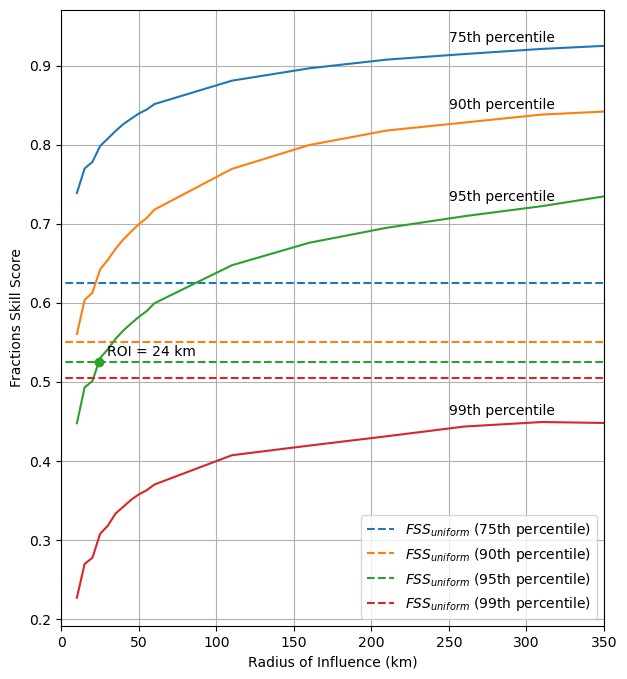

In [12]:
plt.figure(figsize=(7,8))
ax = plt.axes()
ax.grid()
from scipy.interpolate import UnivariateSpline
small_res = np.arange(test_radii.min(),test_radii.max()+0.1,0.1)
colors_list = []
for current_FSS_overall_list_ind in range(len(FSS_lists_with_all_thresholds)):
    spl = UnivariateSpline(test_radii, np.asarray(FSS_lists_with_all_thresholds[current_FSS_overall_list_ind]).mean(axis=0),
                      s=0,k=1)
    curve = ax.plot(test_radii,np.asarray(FSS_lists_with_all_thresholds[current_FSS_overall_list_ind]).mean(axis=0))

    
    f0 = 1 - thresholds_wanted[current_FSS_overall_list_ind]/100
    f0_uniform = 0.5+(f0/2)
    h_plot = ax.hlines(f0_uniform,xmin=-100,xmax=test_radii.max()+100,color=curve[0].get_color(),
                       linestyle='dashed',label='$FSS_{uniform}$ (' + str(thresholds_wanted[current_FSS_overall_list_ind])+'th percentile)')

    ax.set_ylabel('Fractions Skill Score')
    ax.set_xlabel('Radius of Influence (km)')
    ax.annotate(str(thresholds_wanted[current_FSS_overall_list_ind])+'th percentile',(250,spl(300)+0.01))
    if sum(np.unique(f0_uniform - spl(small_res)) < 0) > 0: # Only finds crossing point if line exceeds respective FSS uniform
        min_index_for_line = np.argmin(abs(f0_uniform - spl(small_res)))
        x_cross = small_res[min_index_for_line]
        y_cross = spl(small_res)[min_index_for_line]
        if x_cross > test_radii.min() + 0.5:
            plt.scatter(x_cross,y_cross,color=curve[0].get_color())
            ax.annotate('ROI = ' + str(round(x_cross)) +' km',(x_cross+5,y_cross + 0.007))
            
    colors_list.append(curve[0].get_color(),)

plt.legend()
ax.set_xlim(0,350)
# ax.set_xscale('log')





In [13]:
colors_list

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

In [22]:
test_radii.min()


10.0

In [23]:
f0_uniform - spl(small_res)

array([0.27831633, 0.27746072, 0.27660511, ..., 0.05370533, 0.05370535,
       0.05370536])

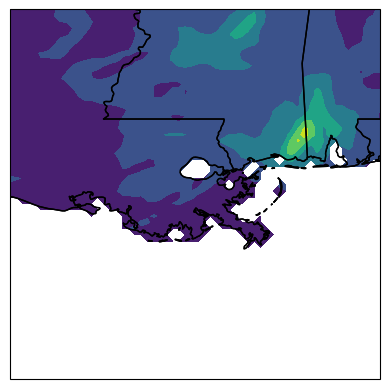

In [24]:
fig7 = plt.figure()
ax7=plt.axes(projection=ccrs.PlateCarree())
ax7.add_feature(cfeature.STATES)
ax7.add_feature(cfeature.COASTLINE)
ax7.contourf(lat_lon_xr[20][1],lat_lon_xr[20][0],mrms_xr[20])

In [25]:
for desired_test_ind in range(len(mrms_xr)):
    fig = plt.figure(figsize=(20, 7)) 

    gs = fig.add_gridspec(1,3)
    ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1,projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1,projection=ccrs.PlateCarree())
    ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1,projection=ccrs.PlateCarree())

    current_time_period = time_strings_list[desired_test_ind]

    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.COASTLINE)

    if np.ceil((mrms_xr[desired_test_ind]).max()) < 10:
        map_interval = 0.5
    elif (np.ceil((mrms_xr[desired_test_ind]).max()) >= 10) and  (np.ceil((mrms_xr[desired_test_ind]).max()) < 20):
        map_interval = 1
    elif (np.ceil((mrms_xr[desired_test_ind]).max()) >= 20) and  (np.ceil((mrms_xr[desired_test_ind]).max()) < 30):
        map_interval = 2    
    elif np.ceil((mrms_xr[desired_test_ind]).max()) >= 30:
        map_interval = 4    


    plot_a = ax.contourf(lat_lon_arr_list[desired_test_ind][1],
                         lat_lon_arr_list[desired_test_ind][0],
                         imerg_xr[desired_test_ind],
                          levels=np.arange(0,np.ceil((mrms_xr[desired_test_ind]).max()),map_interval))

    ax.set_title('IMERG \n' + current_time_period)
    plot_b = ax2.contourf(lat_lon_arr_list[desired_test_ind][1],
                         lat_lon_arr_list[desired_test_ind][0],
                         mrms_xr[desired_test_ind],
                         levels=np.arange(0,np.ceil((mrms_xr[desired_test_ind]).max()),map_interval))

    ax2.add_feature(cfeature.STATES)
    ax2.add_feature(cfeature.COASTLINE)
    ax2.set_title('MRMS \n' + current_time_period)


    ax3.add_feature(cfeature.STATES)
    ax3.add_feature(cfeature.COASTLINE)
    plot_c = ax3.contourf(lat_lon_arr_list[desired_test_ind][1],lat_lon_arr_list[desired_test_ind][0],
                           imerg_xr[desired_test_ind]-mrms_xr[desired_test_ind],cmap='bwr',levels=np.arange(-int(np.ceil(abs(
                                 (imerg_xr[desired_test_ind])-(
                                     mrms_xr[desired_test_ind])).max())),int(np.ceil(
                                 abs(imerg_xr[desired_test_ind]-(
                                     mrms_xr[desired_test_ind])).max()))+0.1,1))
    ax3.set_title('IMERG–MRMS')

    cax_1 = plt.axes([0.105, 0, 0.52, 0.07])
    cax_2 = plt.axes([0.67, 0, 0.23, 0.07])
    # MAKE SURE COLOR LEVELS OF ALL PLOTS ARE SET EQUALLY!!!
    plt.colorbar(plot_b,cax=cax_1,label='Precipitation (in)',orientation='horizontal')
    plt.colorbar(plot_c,cax=cax_2,label='IMERG – MRMS Difference (in)',orientation='horizontal')
    
    plt.savefig('/Users/acheung/data/Figures/mrms_imerg_comparisons/' + current_time_period+'.jpg',bbox_inches='tight')
    plt.close()

In [26]:
def bootstrap(data, R):
 
    means = []
    n = len(data)
 
    for i in range(R):
        sampled_data = data.sample(n=n, replace=True)
        mean = np.nanmean(sampled_data)
        means.append(mean)
 
    return pd.DataFrame(means, columns=['means'])

def confidence_intervals(data, confidence_level=0.95): 
    
    low_end = (1 - confidence_level) / 2
    high_end = 1 - low_end
    bottom_percentile = np.round(data.means.quantile(low_end), 2)
    top_percentile = np.round(data.means.quantile(high_end), 2)
 
    print('The {}% confidence interval is [{}, {}]'.format(
        confidence_level * 100, bottom_percentile, top_percentile))
    return [confidence_level * 100, bottom_percentile, top_percentile,['The {}% confidence interval is {} in to {} in'.format(
        confidence_level * 100, bottom_percentile, top_percentile)]]

In [27]:
diff_xarray = imerg_xr - mrms_xr

diff_pd_flat = abs(pd.DataFrame(diff_xarray.values.ravel()))
bootstrap_means = bootstrap(diff_pd_flat, R=1000)

The 60.0% confidence interval is [0.67, 0.67]
The 70.0% confidence interval is [0.67, 0.68]
The 80.0% confidence interval is [0.67, 0.68]
The 90.0% confidence interval is [0.67, 0.68]
The 95.0% confidence interval is [0.66, 0.68]
The 99.0% confidence interval is [0.66, 0.68]


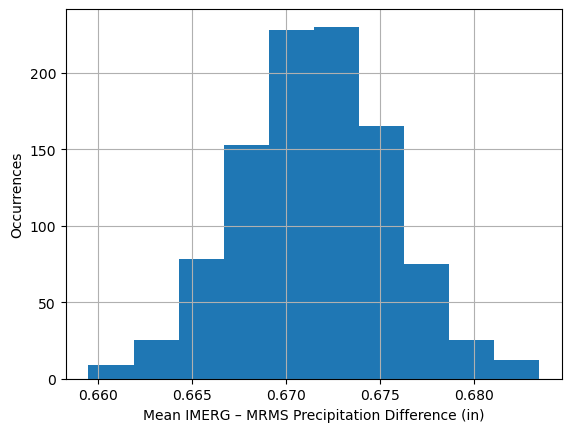

In [28]:
plt.hist(bootstrap_means,density=False)
plt.grid()
plt.ylabel('Occurrences')
plt.xlabel('Mean IMERG – MRMS Precipitation Difference (in)')
all_confidences = []
for ci in [0.6,0.7,0.8,0.9,0.95,0.99]:
    confidences = confidence_intervals(bootstrap_means, confidence_level=ci)
    all_confidences.append(confidences)
    lower_conf = all_confidences[0][1]
    upper_conf = all_confidences[0][2]
    curr_conf_level = all_confidences[0][0]
    

In [29]:
imerg_flat = pd.DataFrame(imerg_xr.values.ravel())
bootstrap_imerg = bootstrap(imerg_flat, R=5000)

The 60.0% confidence interval is [1.6, 1.61]
The 70.0% confidence interval is [1.59, 1.61]
The 80.0% confidence interval is [1.59, 1.61]
The 90.0% confidence interval is [1.59, 1.62]
The 95.0% confidence interval is [1.59, 1.62]
The 99.0% confidence interval is [1.58, 1.63]


Text(0.5, 1.0, 'Mean IMERG Precip over all Storm Total Cases\nThe 95.0% confidence interval is 1.59 in to 1.62 in')

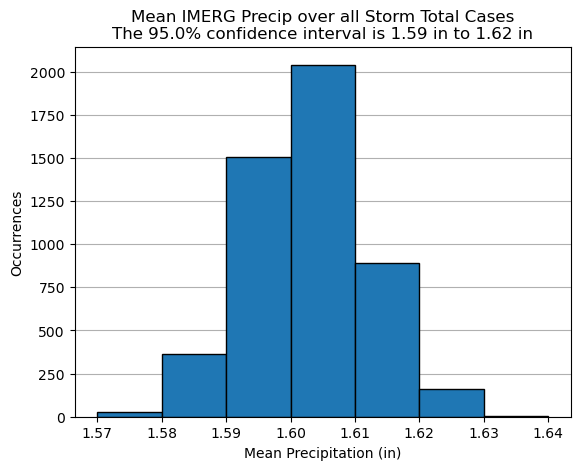

In [50]:
ax1 = plt.axes()
ax1.hist(bootstrap_imerg,density=False,edgecolor='k',bins=np.arange(1.57,1.65,0.01),align='mid')
ax1.set_ylabel('Occurrences')
ax1.set_xlabel('Mean Precipitation (in)')
ax1.grid(axis='y')
ax1.set_axisbelow(True)
all_confidences = []
for ci in [0.6,0.7,0.8,0.9,0.95,0.99]:
    confidences = confidence_intervals(bootstrap_imerg, confidence_level=ci)
    all_confidences.append(confidences)
    lower_conf = all_confidences[0][1]
    upper_conf = all_confidences[0][2]
    curr_conf_level = all_confidences[0][0]
    
ax1.set_title('Mean IMERG Precip over all Storm Total Cases\n' + all_confidences[4][3][0])
    

In [31]:
mrms_flat = pd.DataFrame(mrms_xr.values.ravel())
bootstrap_mrms = bootstrap(mrms_flat, R=5000)

The 60.0% confidence interval is [1.72, 1.74]
The 70.0% confidence interval is [1.72, 1.74]
The 80.0% confidence interval is [1.72, 1.75]
The 90.0% confidence interval is [1.72, 1.75]
The 95.0% confidence interval is [1.71, 1.75]
The 99.0% confidence interval is [1.71, 1.76]


Text(0.5, 1.0, 'Mean MRMS Precip over all Storm Total Cases\nThe 95.0% confidence interval is 1.71 in to 1.75 in')

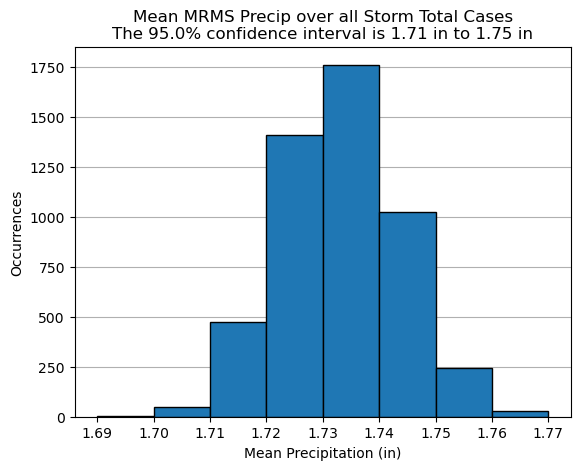

In [49]:
ax2 = plt.axes()
mrms_hist = ax2.hist(bootstrap_mrms,density=False,edgecolor='k',bins=np.arange(1.69,1.77,0.01),align='mid')
ax2.grid(axis='y')
ax2.set_axisbelow(True)
ax2.set_ylabel('Occurrences')
ax2.set_xlabel('Mean Precipitation (in)')
all_confidences = []
for ci in [0.6,0.7,0.8,0.9,0.95,0.99]:
    confidences = confidence_intervals(bootstrap_mrms, confidence_level=ci)
    all_confidences.append(confidences)
    lower_conf = all_confidences[0][1]
    upper_conf = all_confidences[0][2]
    curr_conf_level = all_confidences[0][0]

ax2.set_title('Mean MRMS Precip over all Storm Total Cases\n' + all_confidences[4][3][0])


Text(0.5, 1.0, 'Difference')

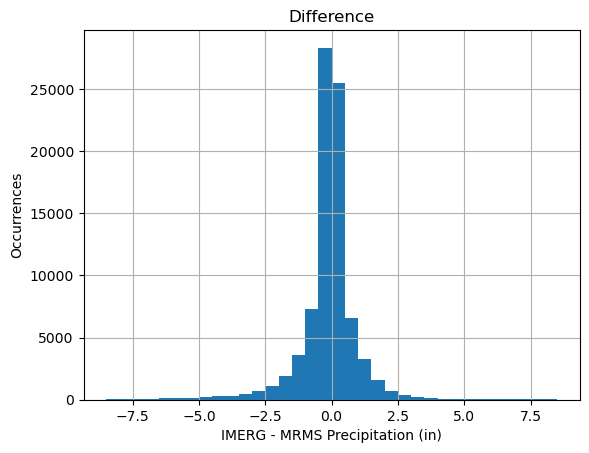

In [33]:
plt.hist(pd.DataFrame(diff_xarray.values.ravel()),bins=np.arange(-8.5,8.6,0.5))
plt.grid()
plt.ylabel('Occurrences')
plt.xlabel('IMERG - MRMS Precipitation (in)')
plt.title('Difference')

Text(0.5, 1.0, 'Mean MRMS Precipitation')

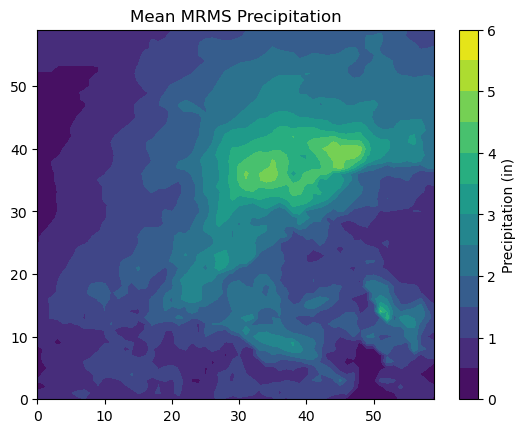

In [34]:
plt.contourf(mrms_xr.mean('dim_0').values,levels=np.arange(0,6.1,0.5))
plt.colorbar(label='Precipitation (in)')
plt.title('Mean MRMS Precipitation')

Text(0.5, 1.0, 'Mean IMERG Precipitation')

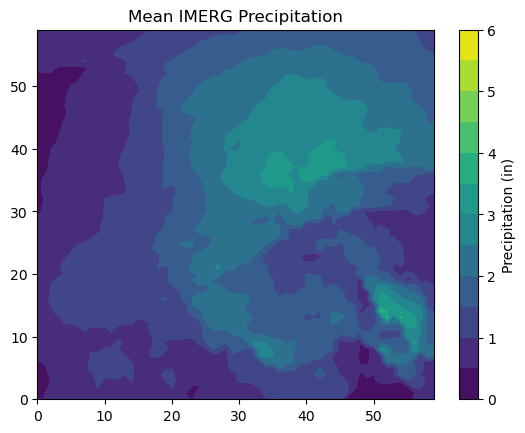

In [35]:
plt.contourf(imerg_xr.mean('dim_0').values,levels=np.arange(0,6.1,0.5))
plt.colorbar(label='Precipitation (in)')
plt.title('Mean IMERG Precipitation')

In [36]:
0.32/imerg_xr.mean(['dim_0','dim_1','dim_2'])

<xarray.DataArray ()> Size: 8B
array(0.19965223)

In [37]:
0.32/mrms_xr.mean(['dim_0','dim_1','dim_2'])

<xarray.DataArray ()> Size: 8B
array(0.18463414)

In [38]:
curr_conf_level

60.0